In [ ]:
original_file_dir = '/content/drive/MyDrive/pneumonia/chest_xray/chest_xray/'
test_dir = '/content/drive/MyDrive/pneumonia/chest_xray/chest_xray/test'
train_dir ='/content/drive/MyDrive/pneumonia/chest_xray/chest_xray/train'
val_dir = '/content/drive/MyDrive/pneumonia/chest_xray/chest_xray/val'
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os


In [ ]:
labels = ['NORMAL', 'PNEUMONIA']
IMG_SIZE = 150
def get_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        #img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        data.append([resized_arr, class_num])
      except Exception as e:
         print(e)
  return np.array(data)




In [ ]:
train = get_data(train_dir)
val = get_data(val_dir)
test = get_data(test_dir)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [ ]:
print(train.shape)
print(train[0][0].shape)

(5216, 2)
(150, 150, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


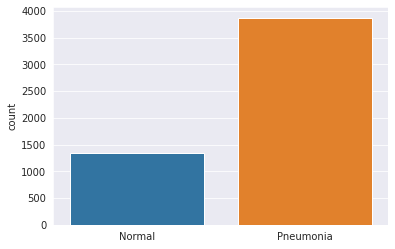

In [ ]:
l = []
for i in train:
    if(i[1] == 1):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'PNEUMONIA')

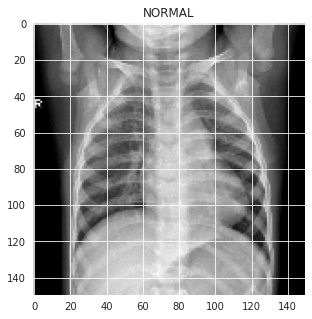

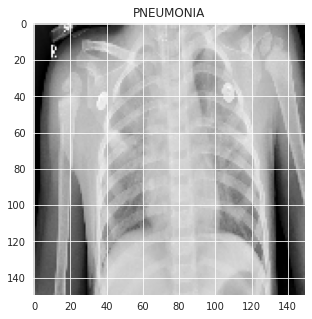

In [ ]:
plt.figure(figsize = (5, 5))
plt.imshow(train[0][0], cmap = 'gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5, 5))
plt.imshow(train[-1][0], cmap = 'gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val =   []
y_val =   []

x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255




In [ ]:
print(x_train.shape, x_val.shape, x_test.shape)

(5216, 150, 150, 3) (16, 150, 150, 3) (624, 150, 150, 3)


In [ ]:
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array(y_test)


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)
datagen.fit(x_val)

In [ ]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16( weights = 'imagenet', include_top = False, input_shape = (150, 150, 3) )
conv_base.summary()

from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense( 256, kernel_regularizer = regularizers.l2(0.001),  activation = 'relu' ))
model.add(layers.Dropout(0.5))
model.add(layers.Dense( 256, kernel_regularizer = regularizers.l2(0.001),  activation = 'relu' ))
model.add(layers.Dropout(0.5))
model.add(layers.Dense( 256, kernel_regularizer = regularizers.l2(0.001),  activation = 'relu' ))
model.add(layers.Dropout(0.5))
model.add(layers.Dense( 1, activation = 'sigmoid'))
conv_base.trainable = False
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
from tensorflow.keras import optimizers
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 2e-5), metrics = ['acc'] )

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
num_epochs = 20
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = num_epochs , validation_data = datagen.flow(x_val, y_val), callbacks = [learning_rate_reduction] )

Epoch 1/20
163/163 [==============================] - 45s 187ms/step - loss: 1.5417 - acc: 0.7074 - val_loss: 1.6387 - val_acc: 0.5000 - lr: 2.0000e-05
Epoch 2/20
163/163 [==============================] - 31s 190ms/step - loss: 1.3035 - acc: 0.7726 - val_loss: 1.4528 - val_acc: 0.6250 - lr: 2.0000e-05
Epoch 3/20
163/163 [==============================] - 30s 181ms/step - loss: 1.1368 - acc: 0.8321 - val_loss: 1.4301 - val_acc: 0.6875 - lr: 2.0000e-05
Epoch 4/20
163/163 [==============================] - 29s 178ms/step - loss: 1.0067 - acc: 0.8706 - val_loss: 1.1546 - val_acc: 0.7500 - lr: 2.0000e-05
Epoch 5/20
163/163 [==============================] - 29s 178ms/step - loss: 0.9196 - acc: 0.8946 - val_loss: 1.3206 - val_acc: 0.8125 - lr: 2.0000e-05
Epoch 6/20
163/163 [==============================] - 29s 178ms/step - loss: 0.8602 - acc: 0.9036 - val_loss: 1.1378 - val_acc: 0.8125 - lr: 2.0000e-05
Epoch 7/20
163/163 [==============================] - ETA: 0s - loss: 0.8218 - acc: 0.90

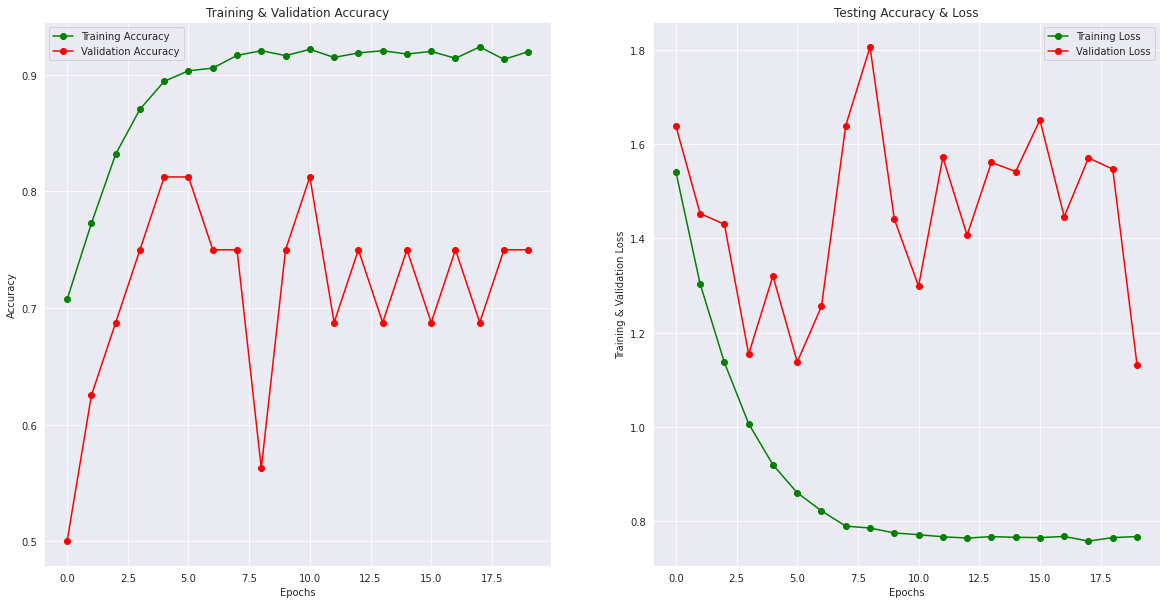

In [ ]:
epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 81ms/step - loss: 0.8499 - acc: 0.8846
Loss of the model is -  0.8498979210853577
20/20 [==============================] - 2s 80ms/step - loss: 0.8499 - acc: 0.8846
Accuracy of the model is -  88.46153616905212 %


In [ ]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               6

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-5), metrics = ['acc'] )


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = num_epochs , validation_data = datagen.flow(x_val, y_val), callbacks = [learning_rate_reduction] )

Epoch 1/20
163/163 [==============================] - 34s 191ms/step - loss: 0.7398 - acc: 0.9241 - val_loss: 1.5210 - val_acc: 0.6875 - lr: 1.0000e-05
Epoch 2/20
163/163 [==============================] - 31s 189ms/step - loss: 0.6989 - acc: 0.9423 - val_loss: 1.3874 - val_acc: 0.8125 - lr: 1.0000e-05
Epoch 3/20
163/163 [==============================] - 31s 188ms/step - loss: 0.6826 - acc: 0.9454 - val_loss: 1.2885 - val_acc: 0.6875 - lr: 1.0000e-05
Epoch 4/20
163/163 [==============================] - ETA: 0s - loss: 0.6569 - acc: 0.9511
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
163/163 [==============================] - 31s 188ms/step - loss: 0.6569 - acc: 0.9511 - val_loss: 1.5892 - val_acc: 0.7500 - lr: 1.0000e-05
Epoch 5/20
163/163 [==============================] - 32s 199ms/step - loss: 0.6375 - acc: 0.9578 - val_loss: 1.2423 - val_acc: 0.8125 - lr: 3.0000e-06
Epoch 6/20
163/163 [==============================] - ETA: 0s - loss: 0.6229 - acc:

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 80ms/step - loss: 0.7206 - acc: 0.9327
Loss of the model is -  0.7205651998519897
20/20 [==============================] - 2s 79ms/step - loss: 0.7206 - acc: 0.9327
Accuracy of the model is -  93.2692289352417 %


In [ ]:
model.save('/content/drive/MyDrive/chestXray_try1.h5')